In [2]:
from qutip import *
import numpy as np
from numpy.polynomial.hermite import hermval
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from scipy import linalg

scale = 1.2
sizeOfFont = scale*15
fontProperties = {'family':'sans-serif','sans-serif':['Helvetica'],
     'size' : sizeOfFont}
rc('text', usetex=True)
rc('font',**fontProperties)
rc('text.latex', preamble=r'\usepackage{sansmathfonts}')
# Fix binomial code parameters
Nval = 4  
Kval = 4
muval = 0 

# Define max dimension of the Hilbert space
N = Kval*Nval +1 # +1 is required because there minimum of Kval*Nval nonzero Fock states plus vacuum

In [3]:
# Destruction operators in the tensor product space of the input
a1 = composite(destroy(N),identity(N))
a2 = composite(identity(N),destroy(N))


# Ideal binomial codewords
def bincode(Nbin, Kbin,mu):
    """Ideal binomial codewords. mu = 0 is the plus logical state."""
    return sum(np.sqrt(math.comb(Kbin, i)/2**Kbin) *((-1)**(i*mu)) * basis(N, i*Nbin) for i in range(Kbin+1))

# Input
psi1 = bincode(Nval, Kval, muval)
psi2 = basis(Nval*Kval, 0)

## Beamsplitter Matrix
# quantum Stokes, eqn 4.6:
Lt = 1/2*(a1.dag()*a1 + a2.dag()*a2)
Lx = 1/2*(a1.dag()*a2 + a2.dag()*a1)
Ly = 1j/2*(a2.dag()*a1 - a1.dag()*a2)
Lz = 1/2*(a1.dag()*a1 - a2.dag()*a2)
def Bmatrix(Φ,Θ,Ψ,Λ):
    """This is the classical matrix given in 4.4, mainly to confirm parameter choice"""
    a = np.exp(1j*Λ/2)
    b = np.array([[np.exp(1j*Ψ/2),0],[0,np.exp(-1j*Ψ/2)]])
    c = np.array([[np.cos(Θ/2),np.sin(Θ/2)],[-np.sin(Θ/2),np.cos(Θ/2)]])
    d = np.array([[np.exp(1j*Φ/2),0],[0,np.exp(-1j*Φ/2)]])
    return a * b @ c @ d

# Beamsplitter Unitary Operator
def B(Φ,Θ,Ψ,Λ):
    """Create the B operator given in 4.12"""
    B = (-1j*Φ*Lz).expm() * (-1j*Θ*Ly).expm() * (-1j*Ψ*Lx).expm() * (-1j*Λ*Lt).expm()
    return B

def createB(T):
    """Creates B unitary operator with transmittance T"""
     # Create a beamsplitter for the simulation
    Θ = 2*np.arccos(np.sqrt(T))
    return B(0,Θ,0,0).dag() # Compute the beamsplitter unitary

# pure vacuum loss and beamsplitter
def pureLossChannel(psi, Loss):
    """Density operator after pure vacuum loss channel"""
    bs = createB(1-Loss)
    state =composite(psi, fock(N, 0)) 
    state = bs*state
    return (state).ptrace([i for i in range(len(dims(psi)[0]))])

def BeamsplitterLossMeasure(psi, T, eta, op):
    """Pure state mixes with vacuum at BS, undergoes (1-eta) loss, and a measurement op"""
    d1      = dims(psi)[0]
    # Extend the Hilbert space with a vacuum mode
    state = composite(psi, fock(N, 0))
    d2      = dims(state)[0]
    # First beamsplitter
    bs      = createB(T)
    state   = bs*state
    # Extend the Hilbert space with a vacuum mode
    state   = composite(state, fock(N,0))
    # Second beamsplitter to simulate loss
    bs2     = composite(identity(d1),createB(eta))
    state   = bs2*state
    state   = (state).ptrace([i for i in range(len(d2))])
    # Construct POVM set
    Pi      = composite(identity(d1), op)
    # tr(rho * rho)
    return (Pi*state*Pi.dag()).ptrace(range(len(d1)))

# k-Photon Subtraction
def kPS(psi, T, eta, k):
    """Density operator after "eta efficient" k-Photon Subtraction at a beamsplitter with transmittance T"""
    # Construct POVM set
    # Pi = composite(identity(d1), fock_dm(N, k))
    # povm = [Pi, composite(identity(d1), identity(N)) - Pi]
    # return (qutip.measurement.measurement_statistics_povm(state, povm )[0][0]).ptrace(0)
    return BeamsplitterLossMeasure(psi, T, eta, fock_dm(N, k))

In [4]:
# DYNE MEASUREMENTS
def psi_n(n,x):
    """Evalutes the <x|n> wavefunction at x
    https://en.wikipedia.org/wiki/Quantum_harmonic_oscillator
    """
    c       = [int(i == n) for i in range(N)]
    Hermite = hermval(x,c)
    coef    = 1/np.sqrt((2**n)*(math.factorial(n)))
    Gauss   = np.exp(-(x**2)/2)
    const   = (np.pi)**(-1/4)
    return coef*const*Gauss*Hermite

def psi_x(x):
    """State |x> = \sum_n{|n><n|x>} constructed in the Fock basis expansion
    alternate: |x> := \hat{O}|0>
    https://physics.stackexchange.com/questions/292899/creating-a-qm-state-of-definite-position-in-fock-space
    """
    return sum( [ psi_n(n,x)*fock(N,n) for n in range(N) ] )
    # a = destroy(N)
    # op = -(1/2) * ( a.dag() - np.sqrt(2)*x )**2  
    # return ( np.exp((x**2)/2) / (np.pi)**(1/4) ) * op.expm()*fock(N, 0)

def Pi_x_density(x):
    """von Neumann projector Pi_x :=  |x> <x|"""
    return ket2dm(psi_x(x))
    


def homodyne(center, Delta, points):
    """Kraus operator that projects the state onto the sum of |x_i><x_i| projectors in a Delta range around center"""
    dx      = Delta/(points-1)
    return dx * sum( [ Pi_x_density(x) for x in np.linspace(center-Delta/2,center+Delta/2, points) ] )


def HOM(psi, T, eta, center, Delta, points):
    """Perform homodyne measurement with T:1-T beasmplitter.
      psi is ket."""
    return BeamsplitterLossMeasure(psi, T, eta, homodyne(center, Delta, points))

In [7]:
# Results
T       = 0.5
eta     = 0.5
center  = 0
Delta   = 0.1
dx      = 1e-4
points = int(Delta/dx +1)

In [5]:
def pts(Delta, dx):
    return int(Delta/dx +1)

def fidelityZPSHOM(psi, T, eta, center, Delta, points):
    """Fidelity between ideal ZPS and HOM heralded output"""
    zps = kPS(psi, T, 1, 0).unit()
    hom = HOM(psi, T, eta, center, Delta, points).unit()
    return fidelity(zps,hom)

def fidelityZPSTHR(psi, T, eta):
    """Fidelity between ideal ZPS and HOM heralded output"""
    zps = kPS(psi, T, 1, 0).unit()
    thr = kPS(psi, T, eta, 0).unit()
    return fidelity(zps,thr)

def DeltaHS(psi0, psi1, psi2):
    return 0.5*metrics.hilbert_dist(psi1, psi0) - 0.5*metrics.hilbert_dist(psi2, psi0) 

def DeltaPS(psi1, psi2):
    return psi1.tr() - psi2.tr()

In [19]:
T       = 0.75 # fix
etaH    = 1 # fix
dx      = 1e-1 

#Plotting
zps     = kPS(psi1, T, 1,   0).unit()

Deltavec= np.linspace(0.5, 2.5,40)
etaTvec = np.linspace(0.15, 0.35, 40)

Psiun = [ [[HOM(psi1, T, etaH, center, i, pts(i,dx)), kPS(psi1, T, j, 0)] for i in Deltavec] for j in etaTvec ]

deltaHS  = [ [ DeltaHS(zps, Psiun[j][i][1].unit(), Psiun[j][i][0].unit()) for i  in range(len(Deltavec))] for j in range(len(etaTvec))]
deltaPS  = [ [ DeltaPS( Psiun[j][i][0], Psiun[j][i][1] ) for i  in range(len(Deltavec))] for j in range(len(etaTvec))]

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

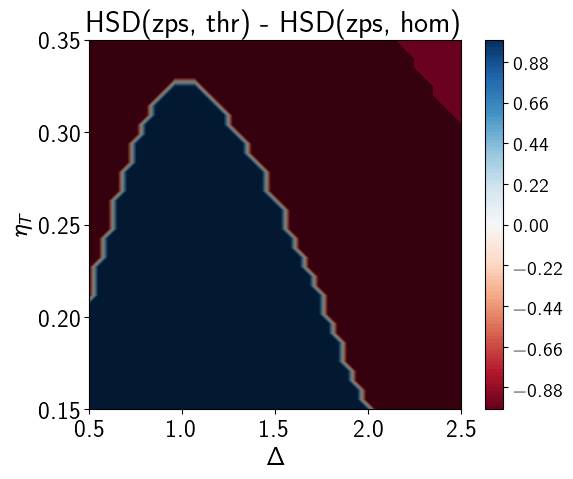

In [13]:
def nrmAmount(mat):
    return max(np.max(mat), np.abs(np.min(mat)))

def nrm(mat):
    return mpl.colors.Normalize(-nrmAmount(mat), nrmAmount(mat) )


from matplotlib.colors import ListedColormap
cmap = plt.cm.Greys
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:, -1] = 0*np.linspace(0, 1, cmap.N)
my_cmap[-2,3] = 0.5
my_cmap[-1,3] = 0.5
my_cmap = ListedColormap(my_cmap)

plt.figure(dpi=100)

cols    = 1
rows    = 1

fig, axes = plt.subplots(rows, cols, figsize=(scale*5*cols,scale*4*rows))


normvalHS = nrm(2*np.heaviside(deltaHS, 0.5)-1)
matHS     = 2*np.heaviside(deltaHS, 0.5)-1

normvalPS = mpl.colors.Normalize(0, nrmAmount(np.heaviside(deltaPS,0.5)) )
matPS   = np.heaviside(deltaPS,0.5)

plots   = axes.contourf(Deltavec, etaTvec,  matHS, 100, cmap=cm.RdBu, norm=normvalHS, zorder = 0) 

axes.contourf(Deltavec, etaTvec,  1-matPS, 100, cmap=my_cmap, norm=normvalPS, zorder = 1) 

axes.set(title = f"HSD(zps, thr) - HSD(zps, hom)",  xlabel = f'$\Delta$',  ylabel = f'$\eta_T$' )

cb      = fig.colorbar(plots, ax=axes) 
cb.ax.tick_params(labelsize = scale*12)

<Figure size 640x480 with 0 Axes>

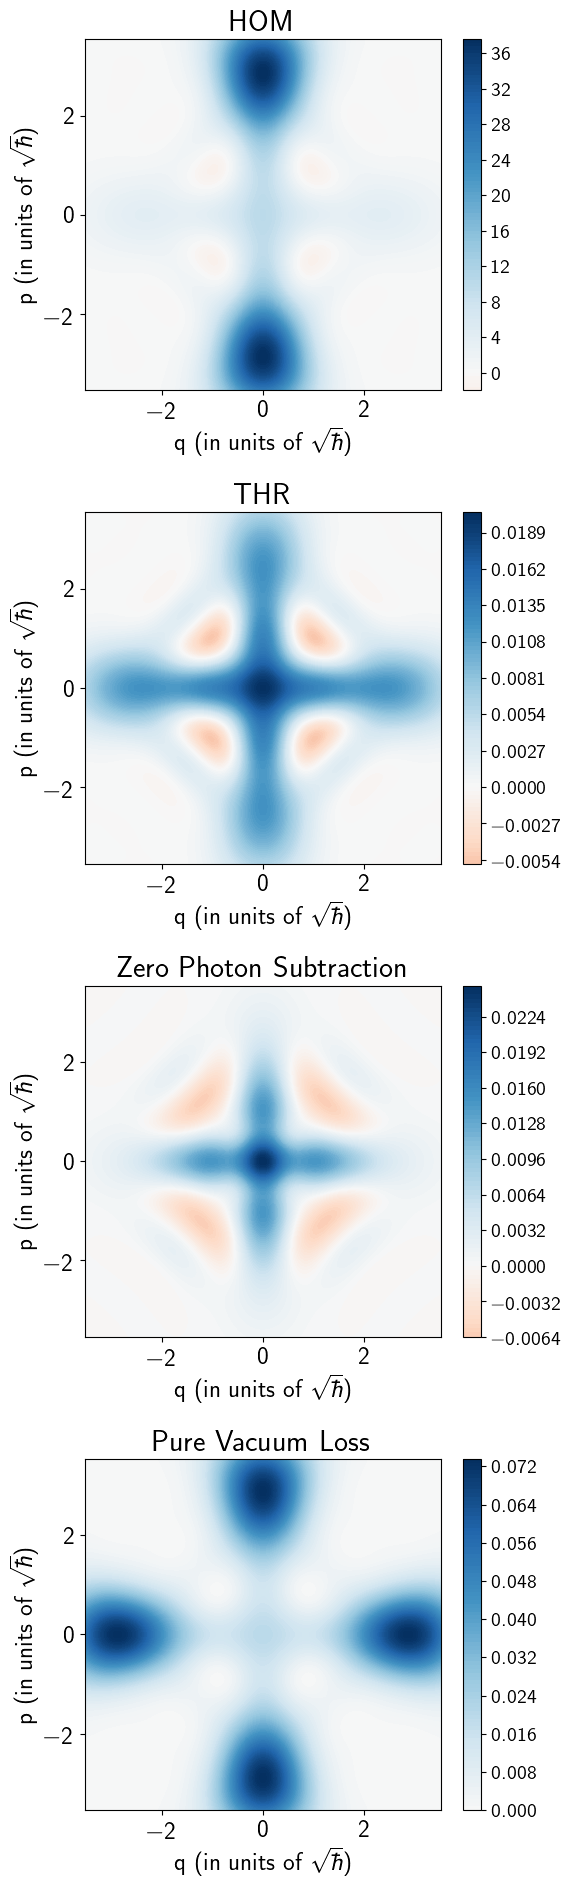

In [18]:
# Results
T       = 0.5
eta     = 0.5
center  = 0
Delta   = 2
points  = 50

outZPS  = kPS(psi1, T, 1,   0).unit()
outTHR  = kPS(psi1, T, eta, 0).unit()
outHOM  = HOM(psi1, T, eta, center, Delta, points).unit()
outLOSS = pureLossChannel(psi1, 1-T).unit()


#Plotting
limi    = 3.5
rang    = 100 
xvec    = np.linspace(-limi, limi, rang)

W       = [wigner(outHOM, xvec, xvec), wigner(outTHR, xvec, xvec), wigner(outZPS, xvec, xvec), wigner(outLOSS, xvec, xvec)]

nrm     = [mpl.colors.Normalize(-W[i].max(), W[i].max()) for i in range(len(W))]

plt.figure(dpi=100)

cols    = 1
rows    = len(W)
fig, axes = plt.subplots(rows, cols, figsize=(scale*5*cols,scale*4*rows))

plots   = [axes[i].contourf(xvec, xvec, W[i], 100, cmap=cm.RdBu, norm=nrm[i]) for i in range(len(W))]

axes[0].set(title = f"HOM",  xlabel = f'q (in units of  $\sqrt\hbar$)',  ylabel = f'p (in units of  $\sqrt\hbar$)' )
axes[1].set(title = f"THR",  xlabel = f'q (in units of  $\sqrt\hbar$)',  ylabel = f'p (in units of  $\sqrt\hbar$)' )
axes[2].set(title = f"Zero Photon Subtraction",         xlabel = f'q (in units of  $\sqrt\hbar$)',  ylabel = f'p (in units of  $\sqrt\hbar$)' )
axes[3].set(title = f"Pure Vacuum Loss",                xlabel = f'q (in units of  $\sqrt\hbar$)',  ylabel = f'p (in units of  $\sqrt\hbar$)' )

cb      = [fig.colorbar(plots[i], ax=axes[i]) for i in range(len(W))]

[cb[i].ax.tick_params(labelsize = scale*12) for i in range(len(W))]

fig.tight_layout()

plt.show()

<Figure size 640x480 with 0 Axes>

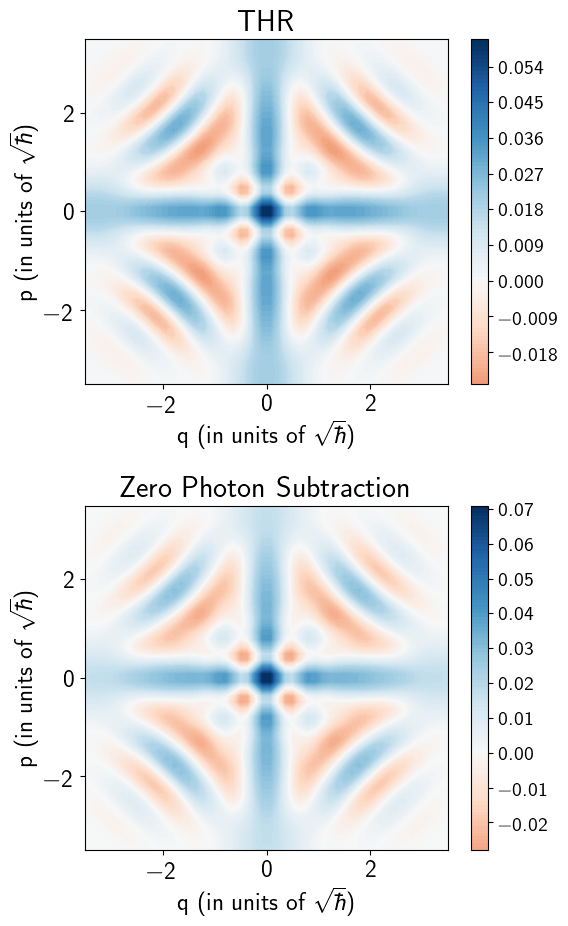

In [334]:
# Results
T = 0.8
eta = 0.85

outZPS  = kPS(psi1, T, 1,   0)
outTHR  = kPS(psi1, T, eta, 0)

#Plotting
limi = 3.5
rang = 50 
xvec = np.linspace(-limi, limi, rang)

W = [ wigner(outTHR, xvec, xvec), wigner(outZPS, xvec, xvec)]

nrm = [mpl.colors.Normalize(-W[i].max(), W[i].max()) for i in range(len(W))]

plt.figure(dpi=100)

cols = 1
rows = len(W)
fig, axes = plt.subplots(rows, cols, figsize=(scale*5*cols,scale*4*rows))

plots = [axes[i].contourf(xvec, xvec, W[i], 100, cmap=cm.RdBu, norm=nrm[i]) for i in range(len(W))]

axes[0].set(title = f"THR",  xlabel = f'q (in units of  $\sqrt\hbar$)',  ylabel = f'p (in units of  $\sqrt\hbar$)' )
axes[1].set(title = f"Zero Photon Subtraction",         xlabel = f'q (in units of  $\sqrt\hbar$)',  ylabel = f'p (in units of  $\sqrt\hbar$)' )

cb = [fig.colorbar(plots[i], ax=axes[i]) for i in range(len(W))]

[cb[i].ax.tick_params(labelsize = scale*12) for i in range(len(W))]

fig.tight_layout()

plt.show()